<a href="https://colab.research.google.com/github/Andyqballer/BigramLanguageModelTransformer.ipynb/blob/main/BigramLanguageModelTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-02 02:31:44--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-05-02 02:31:44 (20.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



step 0: train loss 4.7305, val loss 4.7241
step 0: train accuracy 0.0120
step 300: train loss 2.8066, val loss 2.8217
step 300: train accuracy 0.2268
step 600: train loss 2.5443, val loss 2.5673
step 600: train accuracy 0.2705
step 900: train loss 2.5054, val loss 2.5135
step 900: train accuracy 0.2692
step 1200: train loss 2.4786, val loss 2.5000
step 1200: train accuracy 0.2749
step 1500: train loss 2.4809, val loss 2.4978
step 1500: train accuracy 0.2699
step 1800: train loss 2.4734, val loss 2.4934
step 1800: train accuracy 0.2718
step 2100: train loss 2.4774, val loss 2.4935
step 2100: train accuracy 0.2699
step 2400: train loss 2.4766, val loss 2.4763
step 2400: train accuracy 0.2669
step 2700: train loss 2.4706, val loss 2.4904
step 2700: train accuracy 0.2711

MOLord ghe uio chouxcondorerl cy, Theaman pes$!
LUSANGous wino,
Whath thiveCondswnffo od, hind.
Thathis:
edees nd, inope ms, yony o howhe m.
gher thed of sofatiatherves f het m ssprerh fon, whid prolf.
--g fo brepitor; do

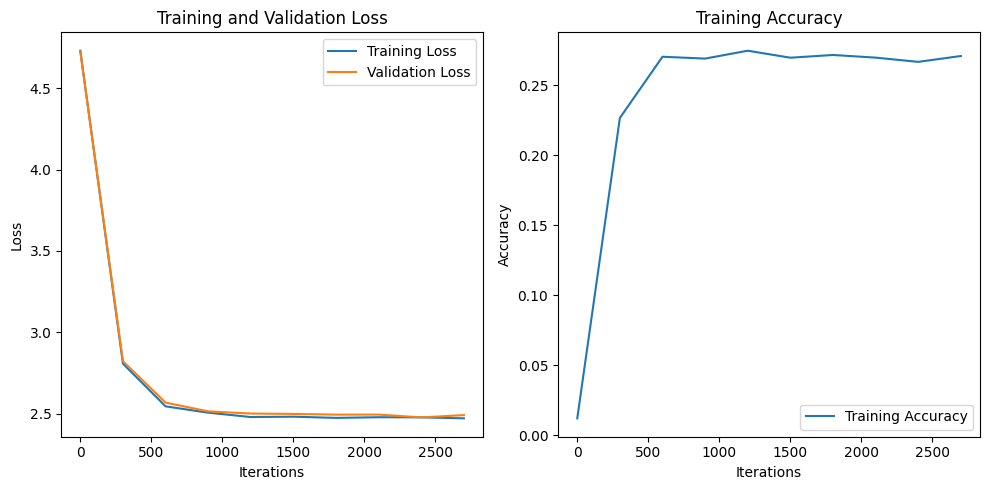

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 32
block_size = 8
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

torch.manual_seed(1337)

# Read input text data
with open('input.txt', 'r', encoding='utf-8') as f: # you can also create a twi_dataset file and replace input.txt with twi_dataset.txt
    text = f.read()

# Create character vocabulary and mappings
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Train and validation splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data loading function
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_accuracies = []  # To store training accuracy

# Training loop
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        train_loss = losses['train']
        val_loss = losses['val']
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

        # Calculate training accuracy
        correct_predictions = 0
        total_predictions = 0
        for _ in range(eval_iters):
            X, Y = get_batch('train')
            logits, _ = model(X)
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == Y).sum().item()
            total_predictions += predictions.numel()
        train_accuracy = correct_predictions / total_predictions
        train_accuracies.append(train_accuracy)
        print(f"step {iter}: train accuracy {train_accuracy:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = decode(m.generate(context, max_new_tokens=6000)[0].tolist())
print(generated_text)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, max_iters, eval_interval), train_losses, label='Training Loss')
plt.plot(range(0, max_iters, eval_interval), val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0, max_iters, eval_interval), train_accuracies, label='Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
